In [1]:
import os, sys
import numpy as np
import scdrs.method as md
from anndata import read_h5ad
import scanpy as sc
import pandas as pd
import os
from os.path import join
from IPython.display import display, Markdown, Latex
import matplotlib.pyplot as plt
import seaborn as sns

def plot_strip(x, y, df, jitter=0.2, alpha=0.5, palette=None, errorbar=False):

    strip_plot = sns.stripplot(
        x=x,
        y=y,
        data=df,
        jitter=jitter,
        alpha=alpha,
        palette=palette,
    )
    strip_plot.set_xticklabels(strip_plot.get_xticklabels())
    strip_plot.tick_params(axis="x", which="major", pad=0)

    if errorbar:
        point_plot = sns.pointplot(
            x=x,
            y=y,
            data=df,
            join=False,
            capsize=0.2,
            errwidth=1.0,
            scale=0.3,
            color="black",
        )
        plt.setp(point_plot.lines, zorder=100)
        plt.setp(point_plot.collections, zorder=100, label="")


# constants
DATA_PATH = "/n/holystore01/LABS/price_lab/Users/mjzhang/scDRS_data"
SCORE_FILE_DIR = join(DATA_PATH, "score_file")

# loading the relevant files
df_obs_dict = dict()
for dataset in ["tms_facs", "tms_droplet"]:
    if dataset == "tms_facs":
        file_name = join(
            DATA_PATH,
            "tabula_muris_senis/tabula-muris-senis-facs-official-raw-obj.h5ad",
        )
    elif dataset == "tms_droplet":
        file_name = join(
            DATA_PATH,
            "tabula_muris_senis/tabula-muris-senis-droplet-official-raw-obj.h5ad",
        )
    df_obs_dict[dataset] = read_h5ad(file_name).obs.copy()

# read scores
score_df_dict = dict()
for dataset in ["tms_facs"]:
    df_obs = df_obs_dict[dataset]
    df_obs["tissue.ct"] = (
        df_obs["tissue"].astype(str) + "." + df_obs["cell_ontology_class"].astype(str)
    )
    if dataset == "tms_facs":
        score_dir = join(
            SCORE_FILE_DIR, "score.tms_facs_with_cov.magma_10kb_top1000_zscore"
        )
    elif dataset == "tms_droplet":
        score_dir = join(
            SCORE_FILE_DIR, "score.tms_droplet_with_cov.magma_10kb_top1000_zscore"
        )
    else:
        raise NotImplementedError

In [2]:
dict_df_gearysc = {
    dset: pd.read_csv(
        f"data/summary_ct/df_gearysc_fdr.{dset}.csv",
        index_col=0,
    )
    for dset in ["tms_facs", "ts_facs", "tms_droplet"]
}

In [3]:
def load_adata(dataset, tissue, trait):
    if dataset in ["tms_facs", "tms_droplet"]:
        adata = sc.read_h5ad(
            f"{DATA_PATH}/tabula_muris_senis/tabula-muris-senis-{dataset.split('_')[1]}-processed-official-annotations-{tissue}.h5ad"
        )
    elif dataset == "ts_facs":
        adata = sc.read_h5ad(
            f"{DATA_PATH}/single_cell_data/tabula_sapiens/obj_smartseq2_raw.h5ad"
        )
        adata = adata[adata.obs.tissue == tissue]
    else:
        raise NotImplementedError
    df_score = pd.read_csv(
        join(
            SCORE_FILE_DIR,
            f"score.{dataset}_with_cov.magma_10kb_top1000_zscore",
            f"{trait}.full_score.gz",
        ),
        sep="\t",
        index_col=0,
    )
    cols = ["norm_score"] + [f"ctrl_norm_score_{i}" for i in range(1000)]
    adata.obs[cols] = df_score[cols].reindex(adata.obs.index)
    return adata


plt_configs = {
    "figure.figsize": (3, 3),
    "axes.titlesize": "small",
    "axes.labelsize": "small",
}
sc.set_figure_params(dpi=100)

In [4]:
def cov_line_plot(df, cov, var_type="continuous"):
    """
    cov: categorical variable for the plot
    """
    df = df.copy()

    assert var_type in ["continuous", "categorical"]
    if var_type == "categorical":
        group_mean = {
            name: group["norm_score"].mean() for name, group in df.groupby(cov)
        }

        plt.plot(
            group_mean.values(),
            ".-",
        )
        plt.xlabel(cov, fontsize=10)
        plt.xticks(
            ticks=np.arange(len(group_mean)),
            labels=list(group_mean.keys()),
            fontsize=10,
        )
        plt.ylabel("Mean scDRS score", fontsize=10)
        data_cor = pearsonr(df[cov].cat.codes, df["norm_score"])[0]
        ctrl_cors = [
            pearsonr(df[cov].cat.codes, df[f"ctrl_norm_score_{i}"])[0]
            for i in range(1000)
        ]
        pval = np.sum(data_cor < ctrl_cors)
        pval = 2 * (min(pval, 1000 - pval) + 1) / 1001
        plt.title(f"Pearson's r={data_cor:.2g}\n(p={pval:.2g})", fontsize=8)
    elif var_type == "continuous":
        # divide into five quintile bins

        q = pd.qcut(df[cov].rank(method="first"), q=5)
        ys = []
        for interval in q.cat.categories:
            interval_cell_index = interval == q
            ys.append(np.mean(df["norm_score"][interval_cell_index]))

        plt.plot(
            ys,
            ".-",
        )
        plt.xlabel(f"{cov} quintile bins", fontsize=10)
        plt.xticks(ticks=np.arange(len(ys)), fontsize=10)
        plt.ylabel("Mean scDRS score", fontsize=10)
        data_cor = pearsonr(df[cov], df["norm_score"])[0]
        ctrl_cors = [
            pearsonr(df[cov], df[f"ctrl_norm_score_{i}"])[0] for i in range(1000)
        ]
        pval = np.sum(data_cor < ctrl_cors)
        pval = 2 * (min(pval, 1000 - pval) + 1) / 1001
        plt.title(f"Pearman's r={data_cor:.2g}\n(p={pval:.2g})", fontsize=8)
    else:
        raise NotImplementedError

In [5]:
def pval2str(p_):
    if p_ > 0.05:
        return "n.s."
    elif p_ > 0.005:
        return "*"
    else:
        return "**"


from scipy.stats import pearsonr


def gene_line_plot(df, gene_list, ax=None):
    """
    cov: categorical variable for the plot
    """
    df = df.copy()
    for gene in gene_list:
        # divide into five quintile bins
        q = pd.qcut(df[gene].rank(method="first"), q=5)
        ys = []
        for interval in q.cat.categories:
            interval_cell_index = interval == q
            ys.append(np.mean(df["norm_score"][interval_cell_index]))

        data_cor = pearsonr(df[gene], df["norm_score"])[0]
        ctrl_cors = [
            pearsonr(df[gene], df[f"ctrl_norm_score_{i}"])[0] for i in range(1000)
        ]
        pval = np.sum(data_cor < ctrl_cors)
        pval = (min(pval, 1000 - pval) + 1) / 1001
        ax.plot(ys, ".-", label=f"{gene} (p={pval:.2g})", alpha=0.7)
        print(f"{gene}: Pearson's r={data_cor:.2g}\n(p={pval:.2g})")

    ax.grid(None)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.legend(fontsize=6)
    ax.set_xlabel(f"Expression quintile bins", fontsize=10)
    ax.set_xticks(np.arange(len(ys)))
    ax.set_xticklabels(labels=np.arange(len(ys)).astype(str), fontsize=10)
    ax.set_ylabel("Mean scDRS score", fontsize=10)

# TMS FACS: spleen / proerythroblast v.s. `UKB_460K.blood_RBC_DISTRIB_WIDTH`

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/frame.py:3636: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[k1] = value[k2]
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/

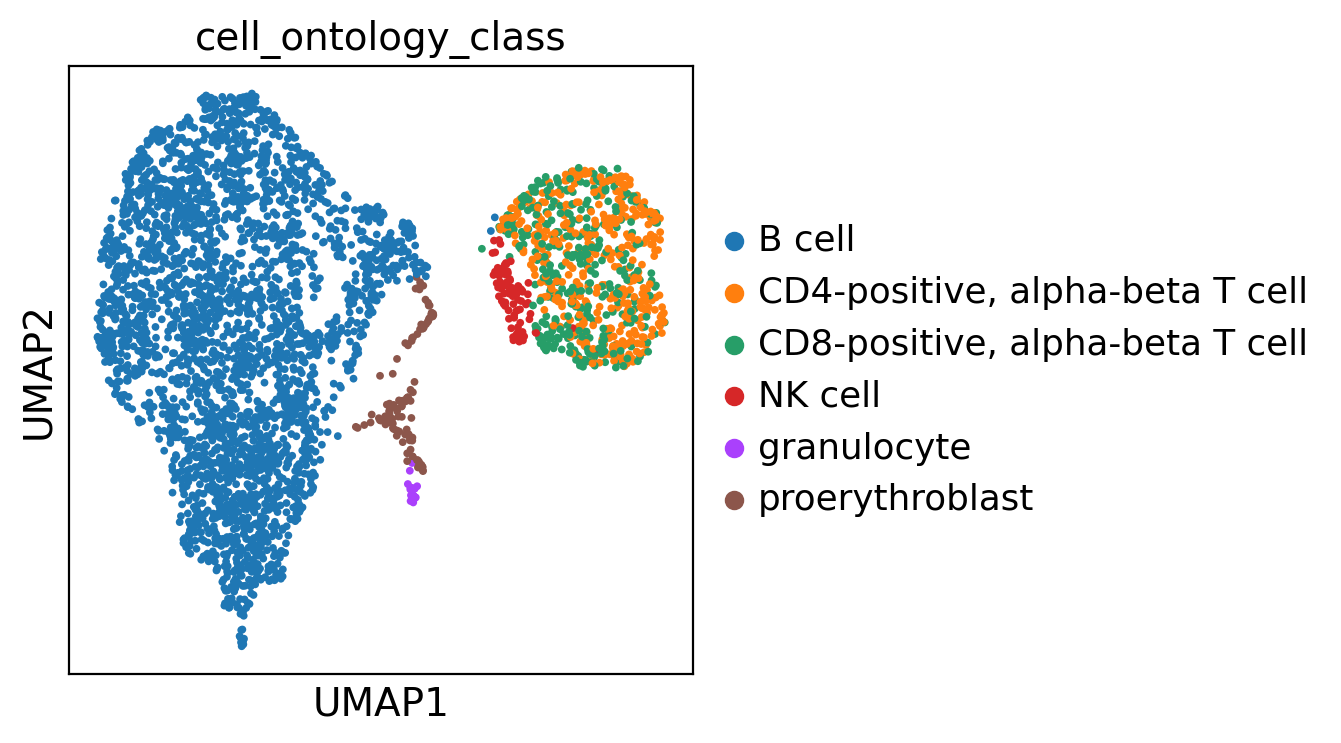

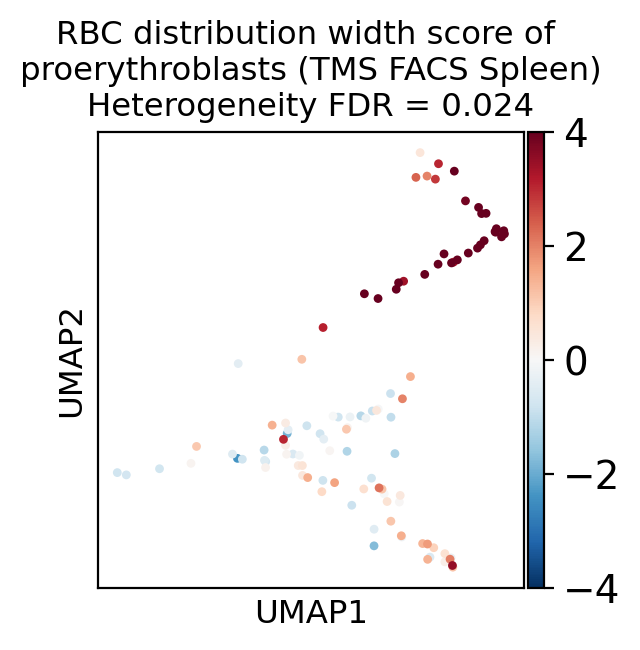

Trying to set attribute `.uns` of view, copying.


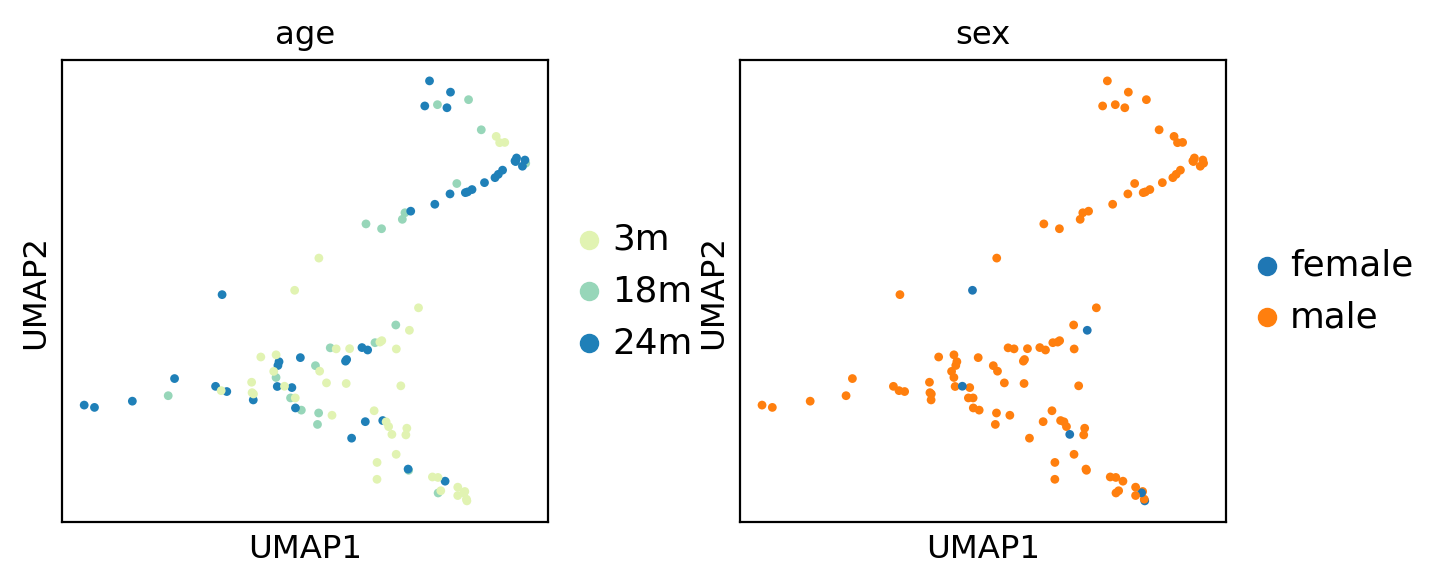

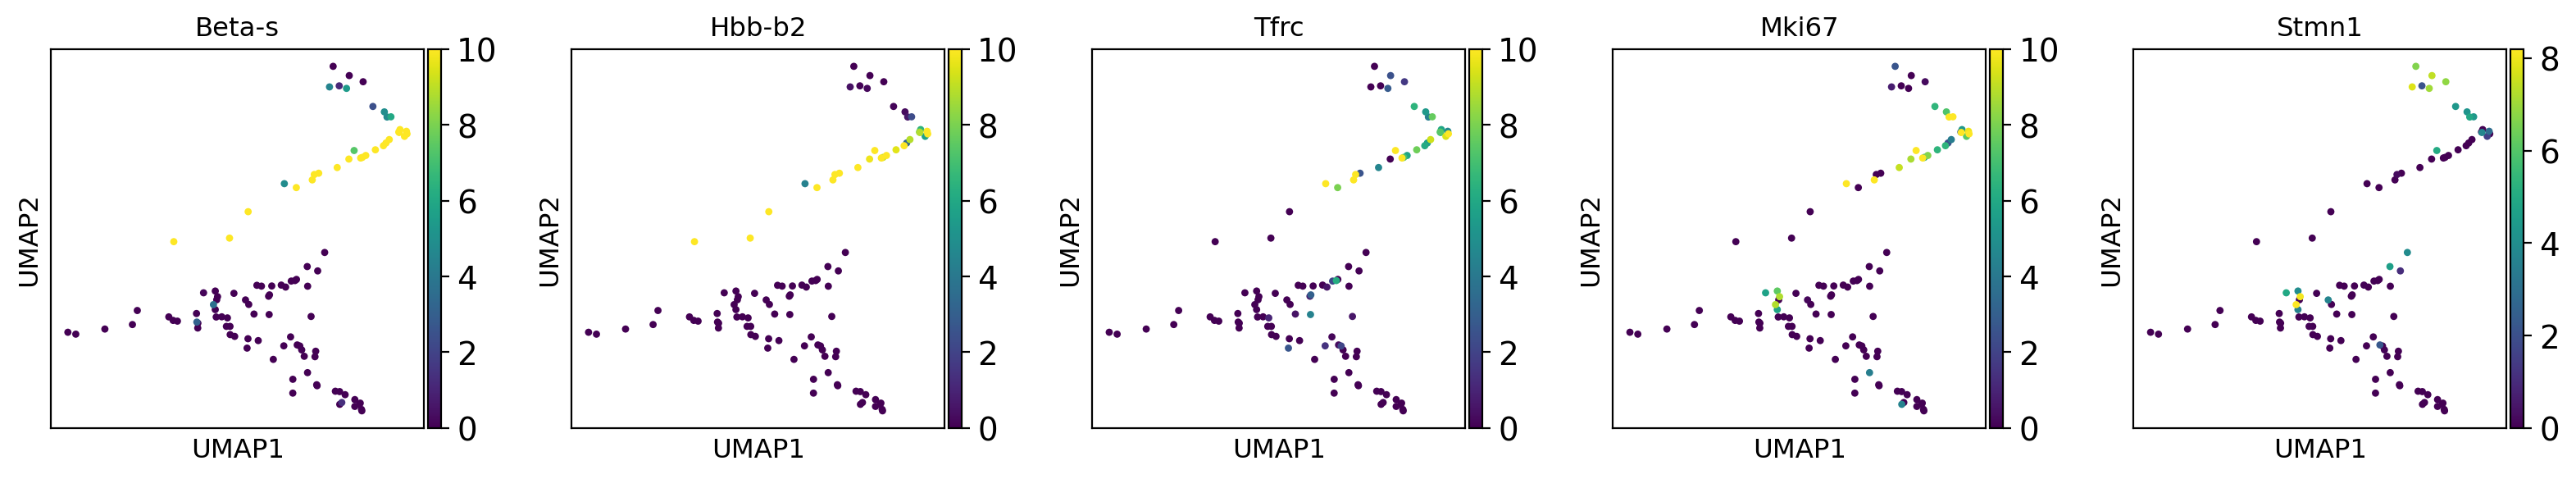

In [6]:
dataset = "tms_facs"
tissue = "Spleen"
celltype = "proerythroblast"
trait = "UKB_460K.blood_RBC_DISTRIB_WIDTH"

adata = load_adata(dataset, tissue, trait)
ct_adata = adata[adata.obs.cell_ontology_class == celltype]
sc.pl.umap(adata, color="cell_ontology_class")
with plt.rc_context(plt_configs):
    fig = sc.pl.umap(
        ct_adata,
        color=["norm_score"],
        cmap="RdBu_r",
        vmin=-4,
        vmax=4,
        size=40,
        title=f"RBC distribution width score of \nproerythroblasts (TMS FACS Spleen)\nHeterogeneity FDR = {dict_df_gearysc[dataset].loc[trait, celltype.replace(' ', '_')]:.2g}",
    )

with plt.rc_context(plt_configs):
    sc.pl.umap(
        ct_adata,
        color=[
            "age",
            "sex",
        ],
        size=40,
        use_raw=False,
    )

    # proerythblast markers
    with plt.rc_context(plt_configs):
        sc.pl.umap(
            ct_adata,
            color=["Beta-s", "Hbb-b2", "Tfrc", "Mki67", "Stmn1"],
            size=40,
            use_raw=False,
            ncols=5,
        )


/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2630: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


Beta-s: Pearson's r=0.8
(p=0.005)
Hbb-b2: Pearson's r=0.72
(p=0.006)
Tfrc: Pearson's r=0.8
(p=0.001)
Mki67: Pearson's r=0.71
(p=0.001)


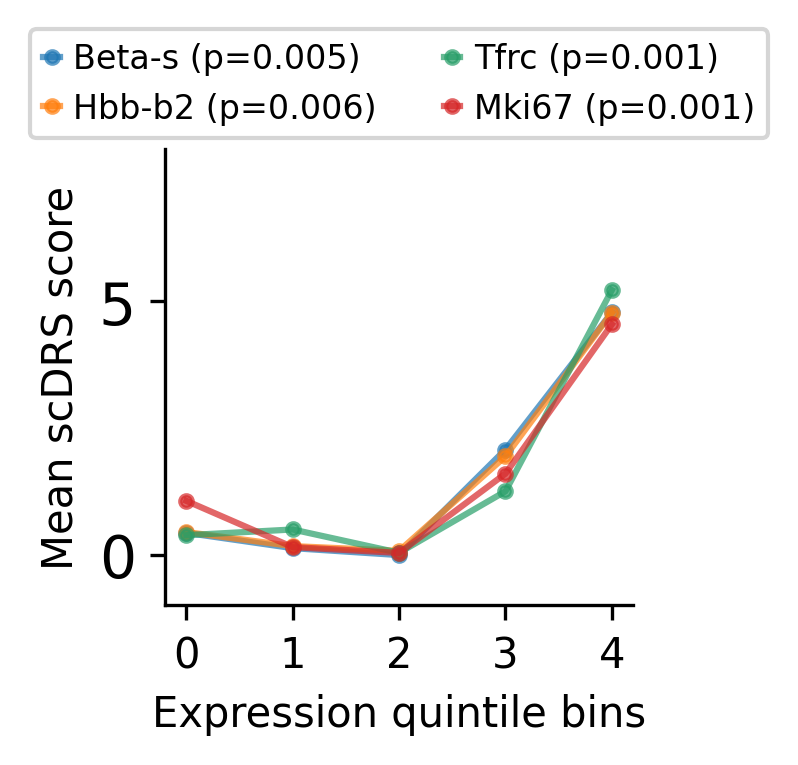

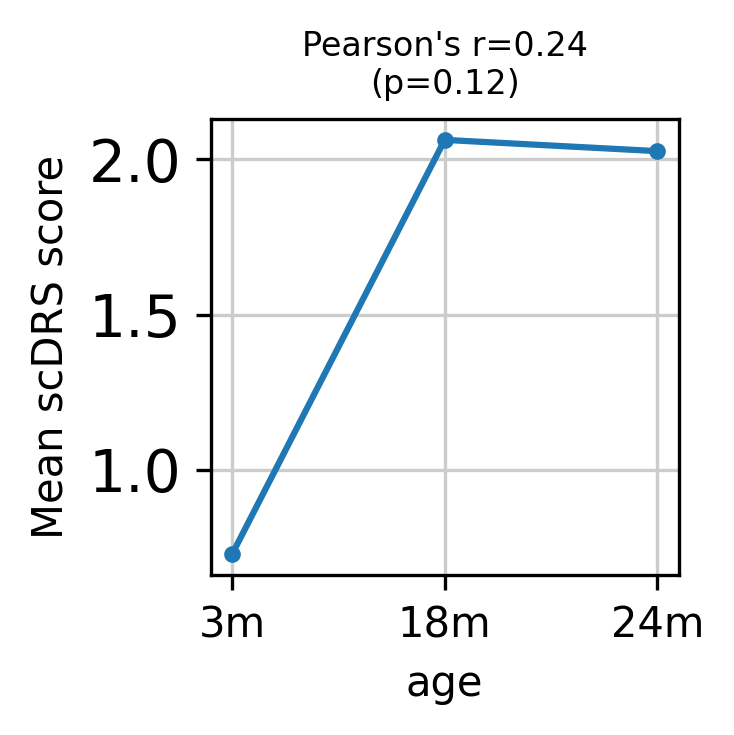

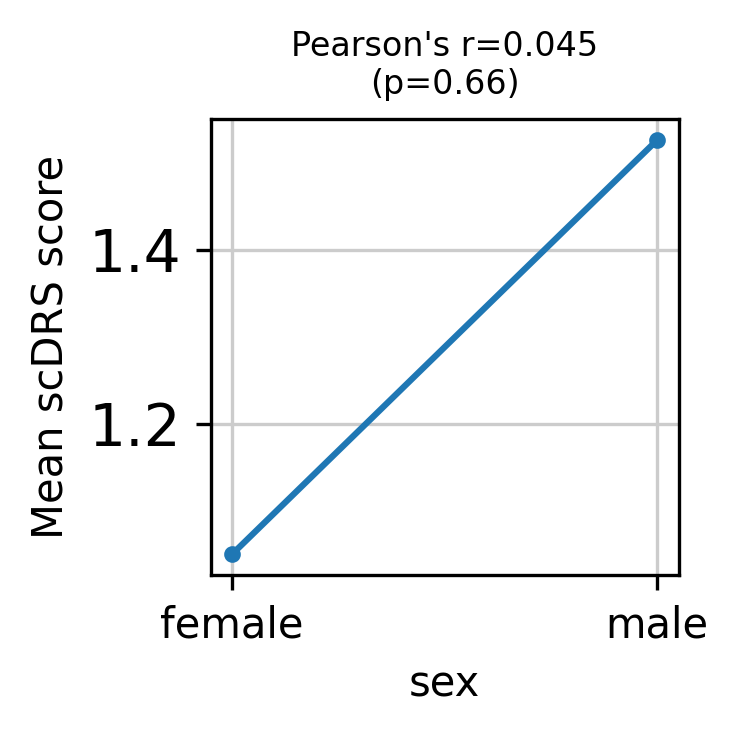

In [7]:
cols = ["norm_score"] + [f"ctrl_norm_score_{i}" for i in range(1000)]
df_plot = ct_adata.obs[["age", "sex"] + cols].copy()

gene_list = ["Beta-s", "Hbb-b2", "Tfrc", "Mki67"]
for gene in gene_list:
    df_plot[gene] = ct_adata[:, gene].X.toarray().flatten()
fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
gene_line_plot(df_plot, gene_list, ax=ax)
ax.legend(ncol=2, fontsize=8, loc="upper center", bbox_to_anchor=(0.5, 1.3))

plt.ylim(-1, 8)

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
cov_line_plot(df_plot, "age", var_type="categorical")

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
cov_line_plot(df_plot, "sex", var_type="categorical")

# TMS FACS: Brain / oligodendrocyte_precursor_cell v.s. `PASS_Schizophrenia_Pardinas2018`

In [ ]:
dataset = "tms_facs"
tissue = "Brain_Non-Myeloid"
celltype = "oligodendrocyte precursor cell"
trait = "PASS_Schizophrenia_Pardinas2018"

adata = load_adata(dataset, tissue, trait)
sc.pl.umap(adata, color=["cell_ontology_class"], ncols=1)
ct_adata = adata[adata.obs.cell_ontology_class == celltype]

with plt.rc_context(plt_configs):
    fig = sc.pl.umap(
        ct_adata,
        color=["norm_score"],
        cmap="RdBu_r",
        vmin=-8,
        vmax=8,
        size=30,
        title=f"Schizophrenia score of \noligodendrocyte precursor cells (TMS FACS Brain)\nHeterogeneity FDR = {dict_df_gearysc[dataset].loc[trait, celltype.replace(' ', '_')]:.2g}",
        return_fig=True,
    )
    ax = fig.axes[0]
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

with plt.rc_context(plt_configs):
    sc.pl.umap(
        ct_adata,
        color=["Pdgfra", "Susd5", "Cspg4"],
        size=40,
        use_raw=False,
        ncols=5,
    )

/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  warn(
/n/holystore01/LABS/price_lab/Users/khou/miniconda3/lib/python3.8/site-packages/anndata/compat/__init__.py:179: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  warn(


In [ ]:
cols = ["norm_score"] + [f"ctrl_norm_score_{i}" for i in range(1000)]
df_plot = ct_adata.obs[["age", "sex"] + cols].copy()

gene_list = ["Pdgfra", "Susd5", "Cspg4"]
for gene in gene_list:
    df_plot[gene] = ct_adata[:, gene].X.toarray().flatten()
fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
gene_line_plot(df_plot, gene_list, ax=ax)
ax.legend(ncol=3, fontsize=7, loc="upper center", bbox_to_anchor=(0.5, 1.15))
plt.ylim(3, 5.5)

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
cov_line_plot(df_plot, "age", var_type="categorical")

fig, ax = plt.subplots(figsize=(2, 2), dpi=150)
cov_line_plot(df_plot, "sex", var_type="categorical")